# インポート

In [1]:
# import packages

# python
import os
from glob import glob

# numpt
import numpy as np

# scipy
import scipy.signal
from scipy.signal import hilbert

# plot
import matplotlib.pyplot as plt

# local
from WavData import WavData
import FileUtil
import SignalProcessingUtil as spu
import NotebookUtil as nu

# データディレクトリ内のファイルを列挙

In [2]:
# enumerate
top_dir = os.environ.get('PWD')
wav_files = glob(os.path.join(top_dir, 'data/*.wav'))

# dump
wav_files

['/workspaces/kick_extractor/data/blue_eyes.wav',
 '/workspaces/kick_extractor/data/Freaking Tight - Alex Prospect_2.wav',
 '/workspaces/kick_extractor/data/last_goodbye_mob.wav',
 '/workspaces/kick_extractor/data/SHOT ME DOWN - Alex Prospect 2_2.wav',
 '/workspaces/kick_extractor/data/Tremor - Alex Prospect & WILSXN_2.wav',
 '/workspaces/kick_extractor/data/02 Dreamer (7iva & saqwz Remix).wav',
 '/workspaces/kick_extractor/data/satellite.wav',
 '/workspaces/kick_extractor/data/happy_days_refrain_20180421_2.wav',
 '/workspaces/kick_extractor/data/save_a_life.wav',
 '/workspaces/kick_extractor/data/Heaven 2017 - Alex Prospect_2.wav',
 '/workspaces/kick_extractor/data/stay_young.wav',
 '/workspaces/kick_extractor/data/Never Forget You - Alex Prospect_2.wav',
 '/workspaces/kick_extractor/data/look_back.wav',
 '/workspaces/kick_extractor/data/WDYWFM - Alex Prospect_2.wav',
 '/workspaces/kick_extractor/data/Need U 100% - Alex Prospect & Spyro_2.wav',
 '/workspaces/kick_extractor/data/all_ab

# 入力ファイルをロード

/workspaces/kick_extractor/source/FileUtil.py:45: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(src_path)


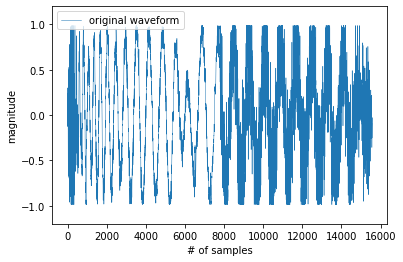

In [3]:
# TODO 決め打ち
src_path = '/workspaces/kick_extractor/data/Need U 100% - Alex Prospect & Spyro_2.wav'

# load
wav_data = FileUtil.load_wav_file(src_path)

# plot
nu.plot_wav_data({'original waveform': wav_data})

# pre-process wav data

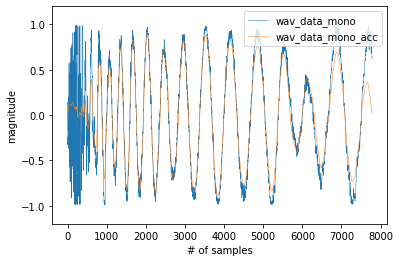

In [4]:
# TODO 決め打ちのパラメータ
beat_per_minute = 170
beat_length_in_sec = 60 / 170
peak_filter_initial_frequency_in_hz = 80
peak_filter_bandwidth_in_hz = 100 #200

# 先頭 1/8 音符分を切り出し
beat_length_in_sample = beat_length_in_sec * wav_data.sample_rate
wav_data_truncated = WavData(wav_data.sample_rate, wav_data.samples[:,:int(beat_length_in_sample/2)])

# モノラルにミックスダウン
wav_data_mono = WavData(wav_data_truncated.sample_rate, np.mean(wav_data_truncated.samples, axis=0))

# 最も大きい正弦波以外の周波数帯をカットオフして「キレイ」にする
wav_data_mono_smoothed_max = np.zeros_like(wav_data_mono.samples)
wav_data_mono_smoothed_min = np.zeros_like(wav_data_mono.samples)
for f in [f for f in np.geomspace(40, 240, 256)]:
    for q in [q for q in np.linspace(100, 200, 25)]:
        wav_data_mono_filtered = spu.apply_peak_filter(wav_data_mono, peak_filter_bandwidth_in_hz, f).samples
        wav_data_mono_smoothed_max = np.fmax(wav_data_mono_smoothed_max, wav_data_mono_filtered)
        wav_data_mono_smoothed_min = np.fmin(wav_data_mono_smoothed_min, wav_data_mono_filtered)
wav_data_mono_smoothed = WavData(wav_data_mono.sample_rate, wav_data_mono_smoothed_max + wav_data_mono_smoothed_min)

# 結果をプロット
nu.plot_wav_data({'original waveform': wav_data_mono, 'smoothed waveform': wav_data_mono_smoothed})

# 極値を探索

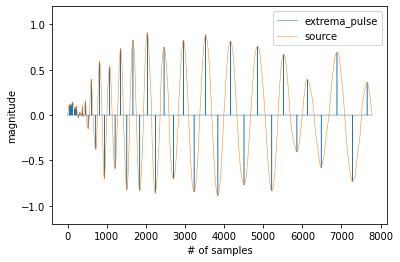

In [6]:
# 極値検出関数
def detect_next_extrema(wav_data: WavData, base_position_in_sample: int, filter_frequency_in_hz: float, direction: int):
    # wav_data_filtered = spu.apply_peak_filter(wav_data, peak_filter_bandwidth_in_hz, filter_frequency_in_hz)
    # extremas = scipy.signal.argrelextrema(wav_data_filtered.samples, np.greater)[0]
    extremas = scipy.signal.argrelextrema(wav_data.samples, np.greater)[0]
    base_position_extremas_index = np.abs(np.asarray(extremas) - base_position_in_sample).argmin()
    next_position_extremas_index = base_position_extremas_index + direction
    if not 0 <= next_position_extremas_index < len(extremas):
        return None
    next_position_in_sample = extremas[next_position_extremas_index]
    next_filter_period_in_sample = abs(base_position_in_sample - next_position_in_sample) * 2.0 # 隣の極値までの距離（サンプル数）は半周期分なので２倍する
    next_filter_period_in_sec = next_filter_period_in_sample / wav_data.sample_rate
    next_filter_frequency_in_hz = 1.0 / next_filter_period_in_sec
    return (next_position_in_sample, next_filter_frequency_in_hz)

# 種となる最初の極値を検出
wav_data_mono_smoothed_abs = WavData(wav_data_mono_smoothed.sample_rate, np.abs(wav_data_mono_smoothed.samples))
initial_extrema_position_in_sample = np.argmax(wav_data_mono_smoothed_abs.samples)

# 初期極値から左（過去）に向けて極値を探索
left_side_extrema_positions_in_sample = []
current_extrema_position_in_sample = initial_extrema_position_in_sample
current_preak_filter_frequency_in_hz = peak_filter_initial_frequency_in_hz
while True:
    detection_result = detect_next_extrema(wav_data_mono_smoothed_abs, current_extrema_position_in_sample, current_preak_filter_frequency_in_hz, -1)
    if detection_result is None:
        break
    current_extrema_position_in_sample, current_preak_filter_frequency_in_hz = detection_result
    if len(left_side_extrema_positions_in_sample) > 0 and current_extrema_position_in_sample > left_side_extrema_positions_in_sample[0]:
        break
    left_side_extrema_positions_in_sample.append(current_extrema_position_in_sample)

# 初期極値から右（未来）に向けて極値を探索
right_side_extrema_positions_in_sample = []
current_extrema_position_in_sample = initial_extrema_position_in_sample
current_preak_filter_frequency_in_hz = peak_filter_initial_frequency_in_hz
while True:
    detection_result = detect_next_extrema(wav_data_mono_smoothed_abs, current_extrema_position_in_sample, current_preak_filter_frequency_in_hz, +1)
    if detection_result is None:
        break
    current_extrema_position_in_sample, current_preak_filter_frequency_in_hz = detection_result
    if len(right_side_extrema_positions_in_sample) > 0 and current_extrema_position_in_sample < right_side_extrema_positions_in_sample[-1]:
        break
    right_side_extrema_positions_in_sample.append(current_extrema_position_in_sample)

# 結合
extrema_positions_in_sample = list(reversed(left_side_extrema_positions_in_sample)) + [initial_extrema_position_in_sample] + right_side_extrema_positions_in_sample
    
# プロット
extrema_pulse = WavData(wav_data_mono_smoothed.sample_rate, np.zeros_like(wav_data_mono_smoothed.samples))
for i in extrema_positions_in_sample:
    extrema_pulse.samples[i] = wav_data_mono_smoothed.samples[i]
nu.plot_wav_data({'extrema': extrema_pulse, 'smoothed waveform': wav_data_mono_smoothed})

# 極端な外れ値を除外
- peak_filter_initial_frequency_in_hz の最近傍極値を始点に探索する
- 極値の極性が隣接極値と反対になってない＝反対になってない隣接極値を外れ値とみなす
- 外れ値で挟まれた閉区間の外側を外れ値として除外する

# 粗い周波数推移を推定
- 極値周辺の周波数を隣接極値との距離を元に粗く推定

# 粗い周波数推移を使って波形を再スムージング

# 詳細な周波数推移を推定
- ゼロ交差点で囲われた「山」に正弦波を当てはめて厳密な極値位置と周波数と最大振幅を推定

# 周波数推移に式を当てはめ
- 周波数の推移データに対して何らかの数式的なモデルを当てはめる
- それによりモデルのパラメータを得る
- 多分 RANSAC か LMeds

# 当てはめ結果を元に波形を再構築
- モデルと推定したパラメータに基づいて正弦波を再生
- ファイルとして保存する
- 1/8 音符ジャストのタイミングで振幅が 0 になるように開始位相を補正する